# Refactored notebook for modelling

## imports

In [1]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import warnings
import re

from NHS_PROMs.load_data import load_proms, structure_name
from NHS_PROMs.preprocess import filter_in_range, filter_in_labels, method_delta
from NHS_PROMs.utils import downcast, map_labels
from NHS_PROMs.data_dictionary import meta_dict

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(display='diagram')

from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import seaborn as sns

## load data
General approach is not DRY for the sake of availability of having knee and hip df's always at hand, but also keep it readable (script-wise).

In [2]:
# load data + rename columns with structired name
df_knee_raw = load_proms(part="knee").apply(downcast).rename(structure_name, axis=1)
# df_hip_raw = load_proms(part="hip").apply(downcast).rename(structure_name, axis=1)

# get meta data for each
full_meta = {t + k: v for k, v in meta_dict.items() for t in ["t0_", "t1_"]}
knee_meta = {k: v for k, v in full_meta.items() if k in df_knee_raw.columns}

df_knee_raw.sample(3)

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
41996,RW6,Knee Replacement,0,2016/17,60 to 69,1.0,2,0,2,2,...,3,2,3,1,1,2,3,2,23.0,33.508232
31116,RN7,Knee Replacement,0,2016/17,50 to 59,1.0,2,0,2,2,...,4,3,3,3,2,3,4,2,38.0,29.298681
44151,RXK,Knee Replacement,0,2018/19,50 to 59,1.0,2,0,2,2,...,1,1,0,0,2,1,1,1,13.0,29.161903


## basic cleaning

In [3]:
endings = (
    "code",
    "procedure",
    "revision_flag",
    "assisted_by",
    "profile",
    "predicted",
)
cols2drop = [c for c in df_knee_raw.columns if c.endswith(endings)]

In [4]:
%%time
df_knee_clean = (
    df_knee_raw.apply(lambda s: filter_in_range(s, **knee_meta[s.name]))
    .apply(lambda s: filter_in_labels(s, **knee_meta[s.name]))
    .apply(lambda s: map_labels(s, **knee_meta[s.name]))
    .query("t0_revision_flag == 'no revision'")
    .drop(columns=cols2drop)
    .reset_index(drop=True)
    #     .replace("missing", np.nan)
)

df_knee_clean.sample(3)

CPU times: user 875 ms, sys: 82.9 ms, total: 958 ms
Wall time: 1.01 s


,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,t1_oks_transport,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score
92584,April 2018 - April 2019,NaN,NaN,no,1 to 5 years,no,alone,no,missing,yes,...,sometimes or just at first,"often, not just at first",most of the time,sometimes or just at first,all of the time,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,32.0
58061,April 2017 - April 2018,60 to 69,female,no,more than 10 years,no,with partner / spouse / family / friends,no,missing,missing,...,rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,all of the time,sometimes or just at first,rarely/never,rarely/never,rarely/never,38.0
150141,April 2019 - April 2020,70 to 79,female,no,1 to 5 years,no,alone,yes,missing,yes,...,sometimes or just at first,rarely/never,rarely/never,rarely/never,all of the time,rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,40.0


## split data

In [5]:
#split train + test set
df_knee = df_knee_clean.query("t0_year != '2019/20'")
df_knee_unseen = df_knee_clean.query("t0_year == '2019/20'")

# df_hip = df_hip_clean.query("t0_year != '2019/20'")
# df_hip_unseen = df_hip_clean.query("t0_year == '2019/20'")

df_knee.sample(3)

,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,t1_oks_transport,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score
142654,April 2019 - April 2020,70 to 79,male,no,6 to 10 years,no,alone,no,missing,missing,...,sometimes or just at first,rarely/never,"often, not just at first","often, not just at first",most of the time,"often, not just at first",sometimes or just at first,sometimes or just at first,"often, not just at first",30.0
93120,April 2018 - April 2019,60 to 69,male,no,more than 10 years,no,with partner / spouse / family / friends,no,missing,missing,...,"often, not just at first",sometimes or just at first,most of the time,sometimes or just at first,"often, not just at first","often, not just at first",sometimes or just at first,sometimes or just at first,"often, not just at first",28.0
108101,April 2018 - April 2019,70 to 79,female,no,6 to 10 years,no,with partner / spouse / family / friends,yes,missing,yes,...,"often, not just at first",sometimes or just at first,"often, not just at first",most of the time,all of the time,sometimes or just at first,sometimes or just at first,rarely/never,"often, not just at first",28.0


## create delta dataframes

In [6]:
df_org = df_knee_clean.apply(
    lambda s: map_labels(s, backwards=True, **knee_meta[s.name])
).apply(np.asarray)

df_knee_delta = method_delta(df_org)
# df_hip_delta = method_delta(df_org)

# now you could join them again with the original df ...
# eg: df_hip_clean.join(df_hip_delta)
df_knee_clean = df_knee_clean.join(df_knee_delta)
df_knee_clean.sample(5)

,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,delta_oks_night_pain,delta_oks_pain,delta_oks_score,delta_oks_shopping,delta_oks_stairs,delta_oks_standing,delta_oks_transport,delta_oks_walking,delta_oks_washing,delta_oks_work
14164,April 2016 - April 2017,70 to 79,male,no,less than 1 year,no,with partner / spouse / family / friends,yes,missing,yes,...,2,4,37.0,4,3,2,3,3,2,3
80862,April 2017 - April 2018,60 to 69,male,no,1 to 5 years,no,with partner / spouse / family / friends,missing,missing,yes,...,4,4,38.0,3,3,3,3,2,3,3
113349,April 2018 - April 2019,60 to 69,female,yes,1 to 5 years,no,with partner / spouse / family / friends,no,missing,missing,...,0,0,6.0,1,1,0,0,-1,0,0
1890,April 2016 - April 2017,NaN,NaN,no,more than 10 years,no,with partner / spouse / family / friends,no,missing,missing,...,-2,0,-8.0,-1,0,-1,0,-1,0,1
143684,April 2019 - April 2020,60 to 69,male,no,6 to 10 years,no,alone,yes,missing,missing,...,0,1,5.0,0,1,1,-1,1,0,1


In [7]:
df_knee_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157657 entries, 0 to 157656
Data columns (total 91 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   t0_year                 157657 non-null  category
 1   t0_age_band             145639 non-null  category
 2   t0_gender               145639 non-null  category
 3   t0_assisted             157657 non-null  category
 4   t0_symptom_period       157657 non-null  category
 5   t0_previous_surgery     157657 non-null  category
 6   t0_living_arrangements  157657 non-null  category
 7   t0_disability           157657 non-null  category
 8   t0_heart_disease        157657 non-null  category
 9   t0_high_bp              157657 non-null  category
 10  t0_stroke               157657 non-null  category
 11  t0_circulation          157657 non-null  category
 12  t0_lung_disease         157657 non-null  category
 13  t0_diabetes             157657 non-null  category
 14  t0_k

## Make feature set

In [8]:
# print(len(df_knee), "original")
print(len(df_knee.dropna()), "after possible total dropna")
(df_knee.isna().sum() / len(df_knee)).sort_values(ascending=False).head(10)

117704 after possible total dropna


t0_eqvas_score       0.091889
t0_age_band          0.076229
t0_gender            0.076229
t0_eq5d_score        0.053420
t1_eqvas_score       0.045352
t1_eq5d_score        0.043468
t1_oks_score         0.017969
t0_oks_score         0.011455
t0_eq5d_mobility     0.000000
t0_eq5d_self_care    0.000000
dtype: float64

In [9]:
# remove NaNs from non categorical/ordinal columns (numerical)
print(len(df_knee), "original")
num_cols = df_knee.select_dtypes(exclude="category").columns
df_knee = df_knee.dropna(subset=num_cols)

print(len(df_knee), "after dropna on numerical")
(df_knee.isna().sum() / len(df_knee)).sort_values(ascending=False).head(10)

157657 original
127686 after dropna on numerical


t0_age_band           0.078176
t0_gender             0.078176
t1_oks_score          0.000000
t1_assisted           0.000000
t0_eq5d_mobility      0.000000
t0_eq5d_self_care     0.000000
t0_eq5d_activity      0.000000
t0_eq5d_discomfort    0.000000
t0_eq5d_anxiety       0.000000
t0_eq5d_score         0.000000
dtype: float64

In [10]:
# # Buggy: TO DO ...
# # s = df_hip["t0_age_band"]

# # def fillna(s, value):
# #     if s.dtype == "category":
# #         print("is cat")
# #         if value not in s.dtype.categories:
# #             print(value, "not in cats")
# #             display(s.dtype)
# #             display(s.dtype.add_categories(value))
# #             s.add_categories(value, inplace=True)
# #             display(s.dtype)
# #     return s.fillna(value)

# # fillna(s, "missing")

# # status before
# display((df_hip.isna().sum() / len(df_hip)).sort_values(ascending=False).head(10))
# print(len(df_hip), "original")

# # remove NaNs from non categorical/ordinal columns (numerical)
# num_cols = df_hip.select_dtypes(include="number").columns
# df_hip = df_hip.dropna(subset=num_cols).fillna("missing")
# print(len(df_hip), "after dropna on numerical")

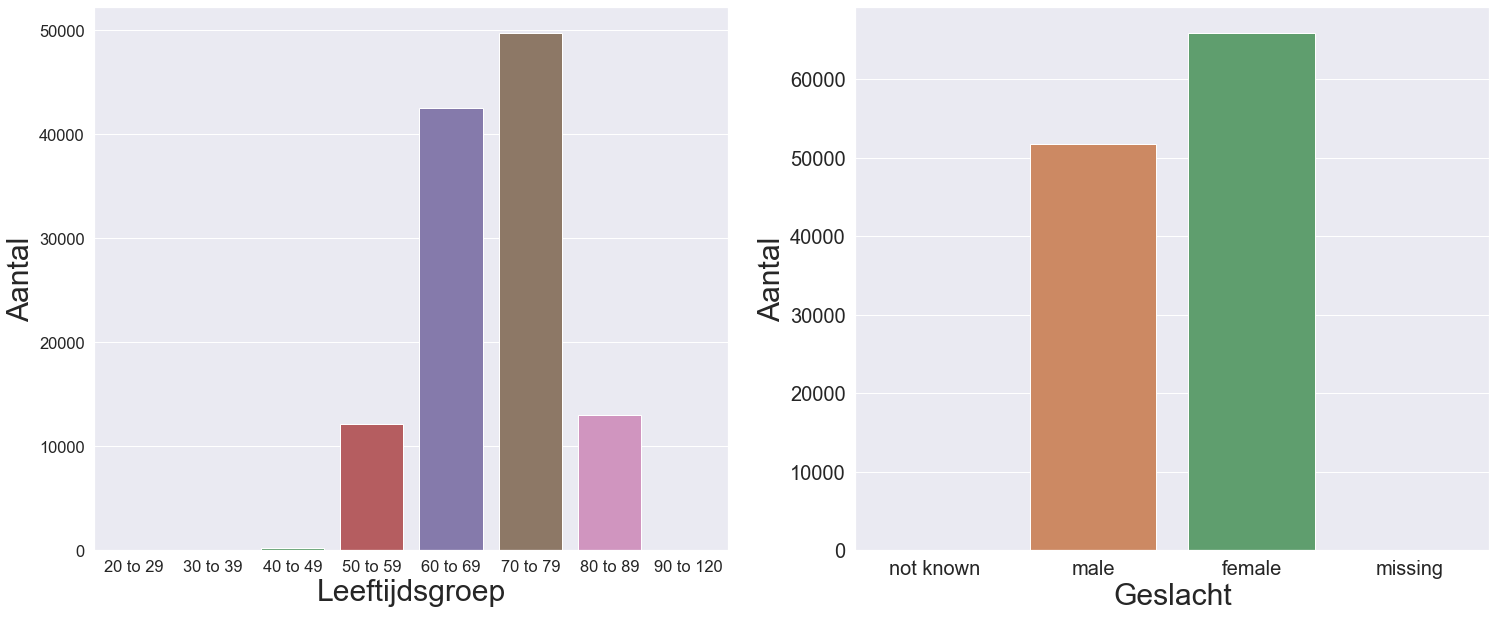

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(25,10))
sns.countplot(x=df_knee['t0_age_band'], ax=ax[0])
sns.countplot(x=df_knee['t0_gender'], ax=ax[1])
plt.set_cmap='hls'
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax[0].set_xlabel('Leeftijdsgroep', fontsize=30)
ax[0].set_ylabel('Aantal', fontsize=30)
ax[1].set_xlabel('Geslacht', fontsize=30)
ax[1].set_ylabel('Aantal', fontsize=30)
plt.show()

## Create Y

### First Y: based on subgroup selection

In [12]:
df_knee_clean['t1_success'].value_counts()

much better        117340
a little better     23622
about the same       6589
a little worse       4916
much worse           3243
missing              1947
Name: t1_success, dtype: int64

In [13]:
# df_knee_clean.drop(df_knee_clean.index[df_knee_clean['t1_success'] == 'missing'], inplace = True)

In [14]:
df_knee_clean['t1_success'].value_counts()

much better        117340
a little better     23622
about the same       6589
a little worse       4916
much worse           3243
missing              1947
Name: t1_success, dtype: int64

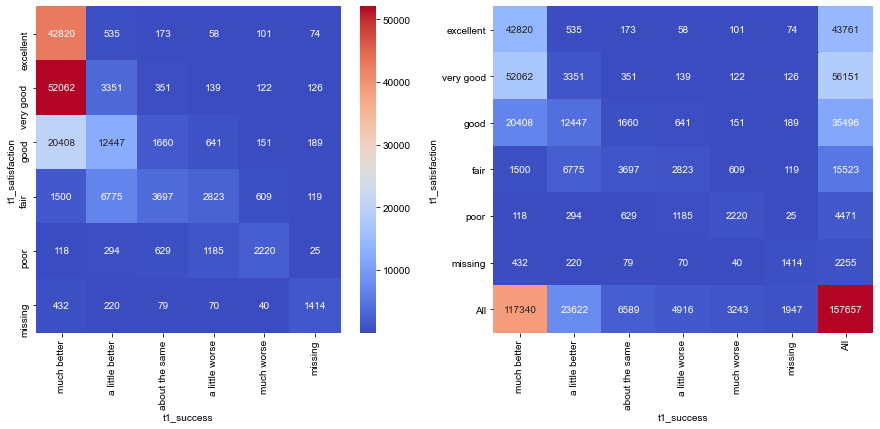

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.heatmap(pd.crosstab([df_knee_clean["t1_satisfaction"]], [df_knee_clean["t1_success"]]), cmap="coolwarm", annot=True, cbar=True, fmt='g', ax=ax[0])
sns.heatmap(pd.crosstab([df_knee_clean["t1_satisfaction"]], [df_knee_clean["t1_success"]], margins=True), cmap='coolwarm', annot=True, fmt='g', cbar=False, ax=ax[1])
sns.set(font_scale=1.5)

In [16]:
def success_rec(recode):
    if recode == 'a little worse':
        return 1
    elif recode == 'much worse':
        return 1
#     elif recode == 'about the same':
#         return 1
    else:
        return 0
    
df_knee_clean['success_recode'] = df_knee_clean['t1_success'].apply(success_rec)
df_knee_clean['success_recode'].value_counts(sort=False)

0    149498
1      8159
Name: success_recode, dtype: int64

<Figure size 1080x576 with 0 Axes>

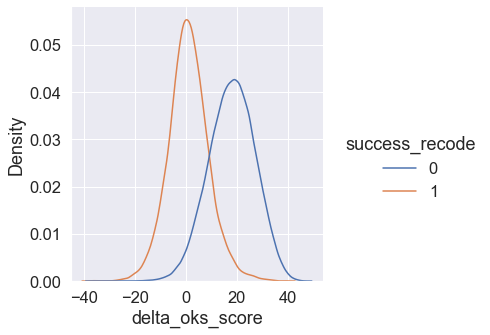

In [17]:
plt.figure(figsize=(15,8))
sns.displot(df_knee_clean, x="delta_oks_score", hue='success_recode', alpha=.5, kind="kde", common_norm=False);

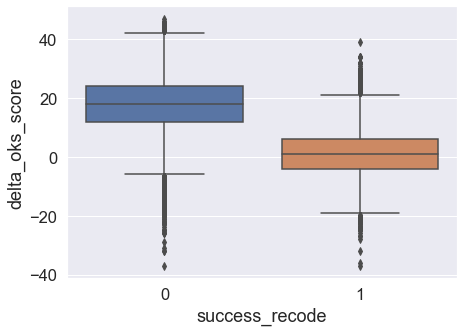

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
fig = sns.boxplot(x=df_knee_clean["success_recode"], y=df_knee_clean['delta_oks_score'], data=df_knee_clean)

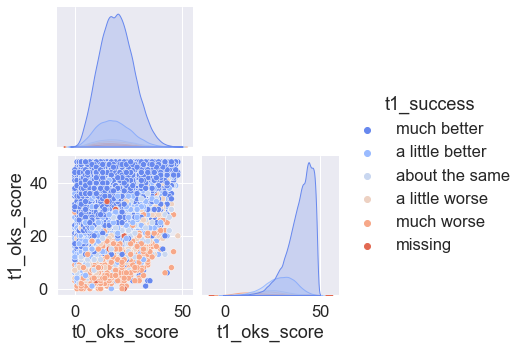

In [19]:
sns.pairplot(data=df_knee_clean[['t0_oks_score','t1_oks_score', 't1_success']],hue='t1_success', palette="coolwarm", corner=True);

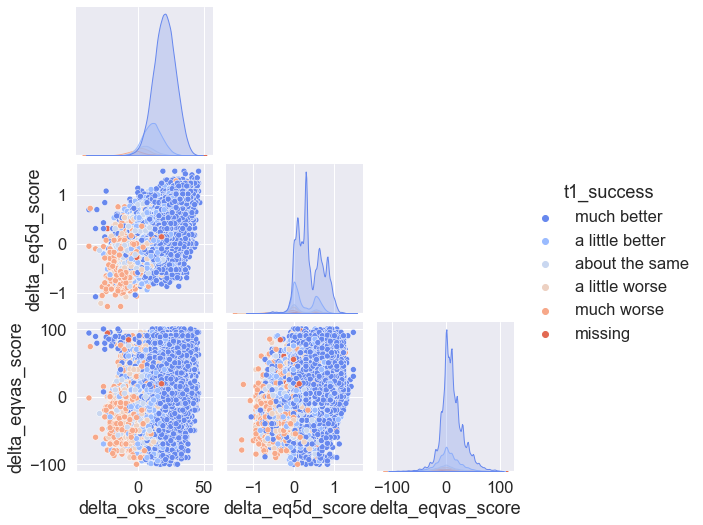

In [20]:
sns.pairplot(data=df_knee_clean[['delta_oks_score', 'delta_eq5d_score', 'delta_eqvas_score', 't1_success']],hue='t1_success', palette="coolwarm", corner=True);

In [21]:
df_knee_clean['delta_oks_score'].groupby(df_knee_clean['success_recode']).mean()

success_recode
0    17.988174
1     1.040852
Name: delta_oks_score, dtype: float32

In [22]:
# def success_rec(recode):
#     if recode == 'a little worse':
#         return 1
#     elif recode == 'much worse':
#         return 1
# #     elif recode == 'about the same':
# #         return 1
#     else:
#         return 0
    
# df_hip['success_recode'] = df_hip['t1_success'].apply(success_rec)
# df_hip['success_recode'].value_counts(sort=False)

In [23]:
df_knee_seen = df_knee_seen.dropna().sample(10_000) # dirty drop for the sake of testing pl

# create x, y
X = df_knee_seen.filter(regex="t0")
y = (df_knee_seen["t1_oks_score"] - df_knee_seen["t0_oks_score"] <= 3).astype(int) # knee <= 3
# y = (df_hip["success_recode"] == 1).astype(int) # hip <= 3

# create train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

NameError: name 'df_knee_seen' is not defined

## show OHE

In [ ]:
# example to show it works
OHE = OneHotEncoder(sparse=False, dtype="uint8")
OHE.fit(X_train)

pd.DataFrame(
    data=OHE.transform(X_train),
    index=X_train.index,
    columns=OHE.get_feature_names(X_train.columns),
)

## make balanced

In [ ]:
print("before:")
display(y_train.value_counts())

cat_cols = X_train.dtypes == "category"

resampler = SMOTENC(categorical_features=cat_cols.values)
X_train_balanced, y_train_balanced = resampler.fit_resample(X_train, y_train)

print("after:")
display(y_train_balanced.value_counts())

## make + train a simple pipeline

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# make the pipeline
ct = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include="category")),
    (StandardScaler(), make_column_selector(dtype_include="number")),
) 

pl = make_pipeline(ct, AdaBoostClassifier())

# train the pipeline/model
pl.fit(X_train_balanced, y_train_balanced)

## predict + evaluate

In [ ]:
# make prediction
y_hat = pl.predict(X_test.head(500))

# evaluate
print(classification_report(y_test.head(500), y_hat))

## extract feature names pl

In [ ]:
# get the feature names from pipeline
def get_feature_names(sklobj, feature_names=[]):

    if isinstance(sklobj, Pipeline):
        for name, step in sklobj.steps:
            get_feature_names(step, feature_names)
    elif isinstance(sklobj, ColumnTransformer):
        for name, transformer, columns in sklobj.transformers_:
            feature_names += get_feature_names(transformer, columns)
    elif isinstance(sklobj, OneHotEncoder):
        feature_names = sklobj.get_feature_names(feature_names).tolist()
    elif isinstance(sklobj, str):
        if sklobj == "passthrough":
            pass
        elif sklobj == "drop":
            feature_names = []
            
    return feature_names

In [ ]:
get_feature_names(pl)

In [ ]:
# # this is slow ...
# r = permutation_importance(pl, X_train.head(1_000), y_train.head(1_000), n_repeats=2, random_state=0)

# feature_names = get_feature_names(pl)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feature_names[i]:<8}"
#         f"{r.importances_mean[i]:.3f}"
#         f" +/- {r.importances_std[i]:.3f}")

## a more advanced pipeline

In [ ]:
# TO DO ...

## debug issue

In [ ]:
data = list("abcebdebca")
categories = list("abcd")

In [ ]:
cats = pd.Categorical(data, categories=categories, ordered=True)
s1 = pd.Series(cats)

display(s1)
s1.cat.categories

In [ ]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=categories, ordered=True)
s2 = pd.Series(data).astype(cat_type)

display(s2)
s2.cat.categories

In [ ]:
s3 = pd.Series(data).astype("category")

display(s3)
s3.cat.categories